In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Loading the data

In [3]:
from pathlib import Path

from rosbags.highlevel import AnyReader
from rosbags.typesys import Stores, get_typestore, get_types_from_idl

import os

from ament_index_python.packages import get_package_share_directory


# getting msg type so rosbags can interpret the data stored
# in the ros bag.
joint_single_idl_path = os.path.join(
    get_package_share_directory('interbotix_xs_msgs'),
    'msg',
    'JointSingleCommand.idl'
)
# Read definitions to python strings.
idl_text = Path(joint_single_idl_path).read_text()

# Plain dictionary to hold message definitions.
add_types = {}

# Add definitions from one idl file to the dict.
add_types.update(get_types_from_idl(idl_text))

typestore = get_typestore(Stores.ROS2_HUMBLE)
typestore.register(add_types)

topic_names = ['/monica/commands/joint_single', '/monica/joint_states']
datasets_path = '../../../datasets/sine_wave_trace_data'
ros_bag = 'sine_wave_test_1'

bagpath = Path(os.path.join(datasets_path, ros_bag))

# Create reader instance and open for reading.
with AnyReader([bagpath], default_typestore=typestore) as reader:
    joint_cmd_connection = [x for x in reader.connections if x.topic == topic_names[0]]
    joint_states_connection = [x for x in reader.connections if x.topic == topic_names[1]]
    
    # This variable will save the time at which the ros bag started
    # collecting data
    start = 0.0

    joint_states = {
        'time': [],
        'wrist_angle': []
    }

    for connection, timestamp, rawdata in reader.messages(connections=joint_states_connection):
        msg = reader.deserialize(rawdata, connection.msgtype)
        # amount of time that has passed in seconds
        time = timestamp / 1e9
        joint_states['time'].append(time)
        joint_states['wrist_angle'].append(msg.position[3])

    # turning joint_states into a pandas dataframe
    joint_states = pd.DataFrame(joint_states)
    # joint_states was the first to publish to the ros bag,
    # so the smallest entry in joint_states represents the time
    # when data first started to be collected
    start = joint_states['time'].min()

    # turning the times in joint_states into relative times
    joint_states['time'] = joint_states['time'].apply(lambda t: t - start)

    joint_cmds = {
        'time': [],
        'cmd': []
    }

    for connection, timestamp, rawdata in reader.messages(connections=joint_cmd_connection):
        msg = reader.deserialize(rawdata, connection.msgtype)
        # amount of time that has passed in seconds
        time = (timestamp / 1e9) - start
        cmd = msg.cmd
        
        joint_cmds['time'].append(time)
        joint_cmds['cmd'].append(cmd)


    joint_cmds = pd.DataFrame(joint_cmds)
    joint_cmds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12348 entries, 0 to 12347
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    12348 non-null  float64
 1   cmd     12348 non-null  float64
dtypes: float64(2)
memory usage: 193.1 KB


## Data Preprocessing

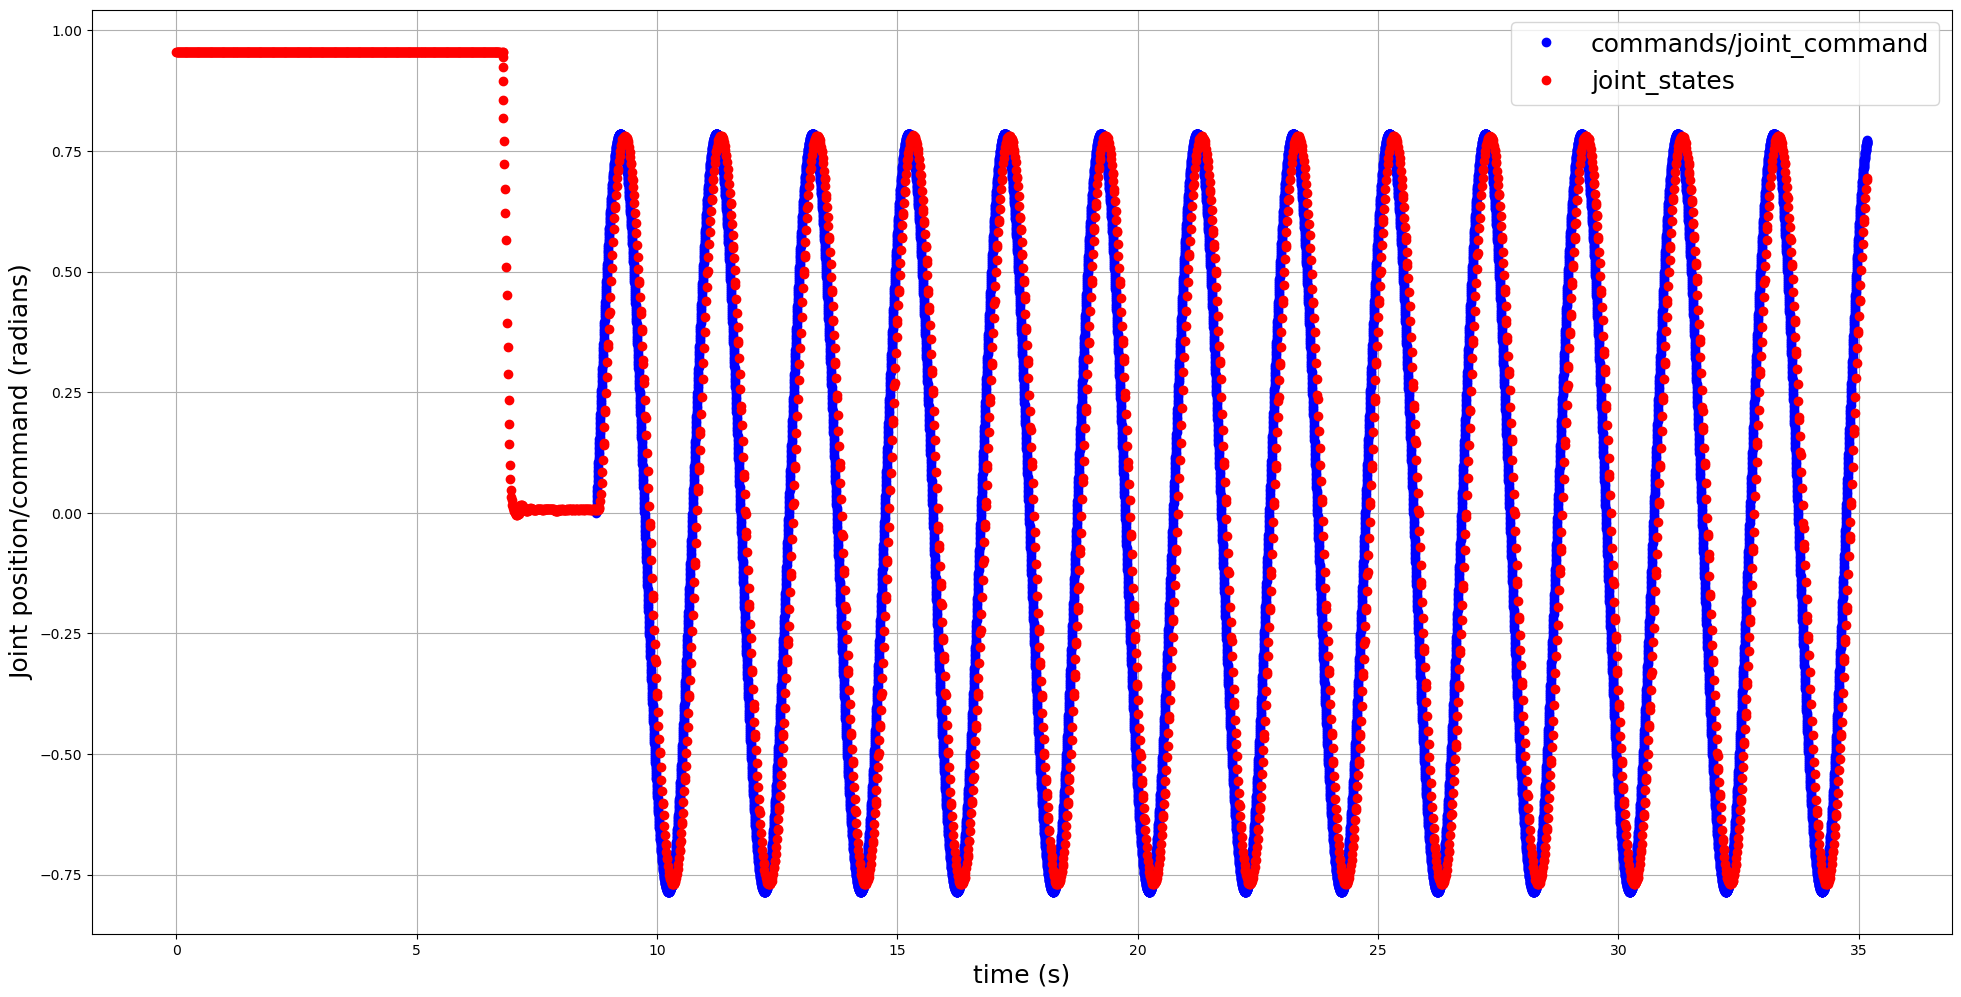

In [4]:
plt.figure(figsize=(24, 12))
plt.plot(joint_cmds['time'], joint_cmds['cmd'], 'ob')
plt.plot(joint_states['time'], joint_states['wrist_angle'], 'or')
plt.xlabel('time (s)', fontsize=18)
plt.ylabel('Joint position/command (radians)', fontsize=18)
plt.legend(['commands/joint_command', 'joint_states'],
           loc="upper right", fontsize=18)
plt.grid(True)
plt.show()

In [5]:
print(f'Smallest value in joint_cmds: {joint_cmds['time'].min()}')
print(f'Smallest value in joint_states: {joint_states['time'].min()}')
joint_states = joint_states[joint_states['time'] >= joint_cmds['time'].min()]
print(joint_states.info())

Smallest value in joint_cmds: 8.737285137176514
Smallest value in joint_states: 0.0
<class 'pandas.core.frame.DataFrame'>
Index: 2259 entries, 874 to 3132
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         2259 non-null   float64
 1   wrist_angle  2259 non-null   float64
dtypes: float64(2)
memory usage: 52.9 KB
None


The previous plots and the code cell clearly show the sine wave publisher didn't start publishing commands until about 8.7 seconds after execution. So, we should exclude the data in joint_states where the time is less than 8.7 seconds.

There are also two more things to consider with this data.
- The joint_states topic publishes the position of the arm using 64-bit FP values. But, the joint commands are published as 32-bit FP values.
- Joint states publishes data at a much slower rate than than our sine wave publisher. This can clearly be seen in plots.

This means it's very difficult to compare values because they are rarely equal to each other.

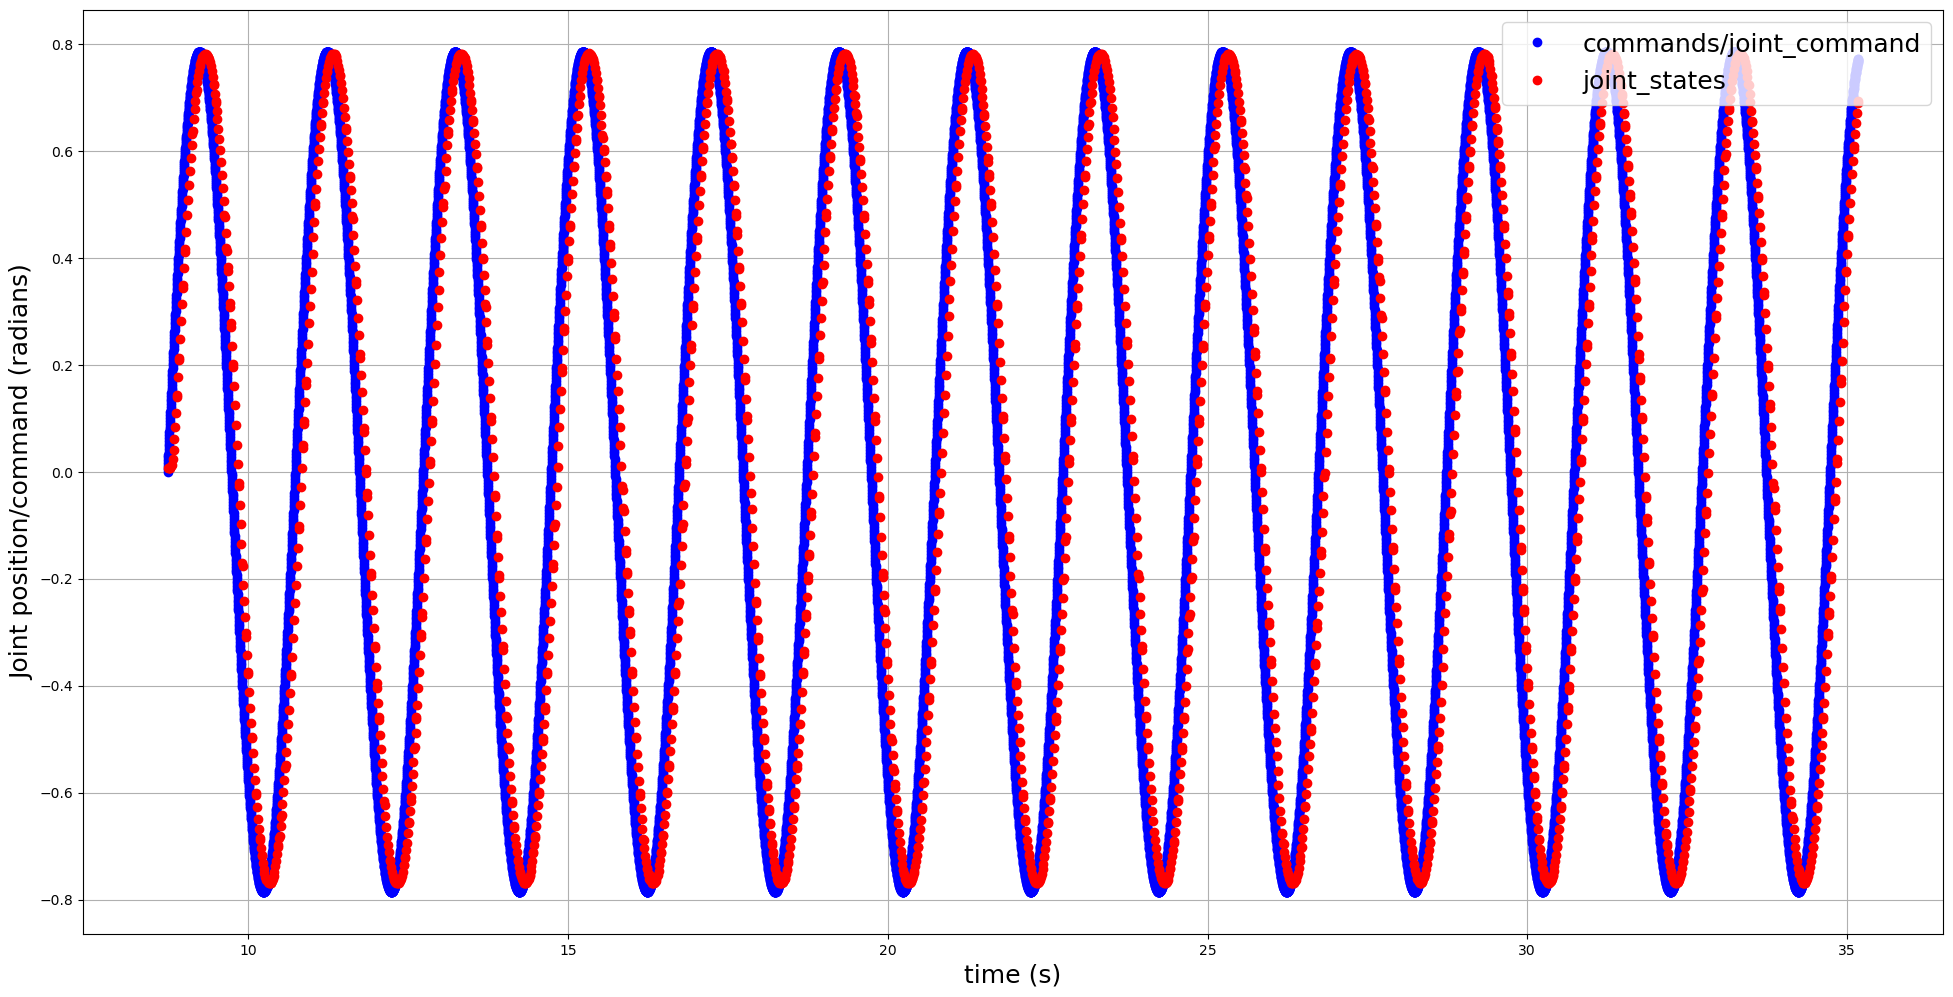

In [6]:
plt.figure(figsize=(24, 12))
plt.plot(joint_cmds['time'], joint_cmds['cmd'], 'ob')
plt.plot(joint_states['time'], joint_states['wrist_angle'], 'or')
plt.xlabel('time (s)', fontsize=18)
plt.ylabel('Joint position/command (radians)', fontsize=18)
plt.legend(['commands/joint_command', 'joint_states'], loc="upper right", fontsize=18)
plt.grid(True)
plt.show()

## Computing the Average Time Difference

Due to the fact comparing the values is difficult, I used a different method for computing the average time difference. Basically, for each point in the joint_states data, the difference between that point and all of the points in the joint_cmds data is calculated. Then, the smallest difference is the only one kept. Once this is finished, the mean of these points is computed, and is roughly 0.0003 seconds.

In [7]:
# creating a numpy array to store each time difference
time_differences = np.array([])

for time in joint_states['time']:
    # computing the minimum time difference
    min_time = joint_cmds['time'].apply(lambda t: abs(time - t)).min()
    time_differences = np.append(time_differences, min_time)

time_differences.mean()

0.00033381830648597017